In [1]:
import gcp.bigquery as bq
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model

# Variables

## Levers

In [178]:
# Registration levers
weekly_regs_factor=0.00
viral_factor=0.00

# Activation
newly_activate_rate=0.00
act_rate=0.00

# Retention new users
second_week_retention=0.00
# Number of weeks the 2nd day retention is sustained. There is no point having it larger then "new_tp_weeks" 
new_ret_sus_weeks=18

# Retention existing user
wow_ret=0.00
wow_res=0.00
wu=0.00 # implement later

# include start and end week
start=1
end=52

## Other parameters

In [183]:
# Partition dates
current_date = '2016-12-02'
current_date_short = 20161202

# Number of weeks we use cohort tranition probabilities for new registrations. After this many week the will enheritage existing users TP
new_tp_weeks=52

#How many weeks old an existing player is required to be. Also the number of weeks we have "missing hole" registrations
ex_weeks_req=18

#The number of weeks to make forecast
num_forecast_weeks=52

#Number of weeks used for linear forecast of new registrations
linear_weeks=26

# If hole_flag=1, then new users get the wow_ret etc... in same logic as existing users, if=0 then as in excel cheet
hole_flag=1

# Get result

##### Test group

In [184]:
bq_data=[ex_tp,df_ex,ex_matrix_start, df_new_num, df_new_tp]
levers=[weekly_regs_factor, viral_factor, newly_activate_rate, act_rate, second_week_retention, new_ret_sus_weeks, wow_ret, wow_res, wu, start, end]
parameters=[new_tp_weeks, ex_weeks_req, num_forecast_weeks, linear_weeks, hole_flag]
all=levers+parameters+bq_data
active_test, resulting_state_test=end_result_MAU(*all)

##### Control group

In [185]:
bq_data_c=[ex_tp,df_ex,ex_matrix_start, df_new_num, df_new_tp]
levers_c=[0, 0, 0, 0, 0, 18, 0, 0, 0, 1, 52]
parameters_c=[new_tp_weeks*0+18, ex_weeks_req, num_forecast_weeks, linear_weeks, hole_flag]
all_c=levers_c+parameters_c+bq_data
active_control, resulting_state_control=end_result_MAU(*all_c)

##### Plot result

52   -0.030465
dtype: float64

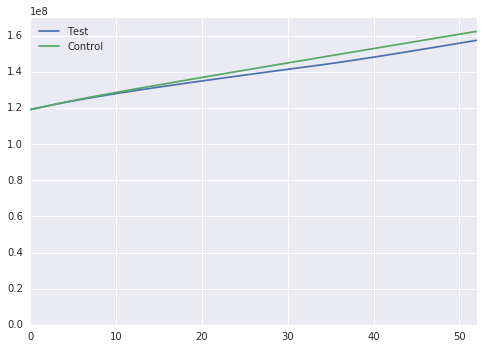

In [186]:
active=active_test

active['Test']=active_test['Tot']
active['Control']=active_control['Tot']
active=active[['Test', 'Control']]

ax1=active.plot()
ax1.set_ylim(0,)
diff=((active['Test']-active['Control'])/active['Control'])
diff[-1:]

# Get data from BigQuery

### New users TP (change 18 weeks thing?)

In [180]:
%%sql -m sql_new_tp
SELECT
remain_fta / (remain_fta + activate) AS remain_fta,
activate / (remain_fta + activate) AS activate,
retain / (retain + churn) AS retain,
churn / (retain + churn) AS churn,
resurrect / (resurrect + remain_dormant) AS resurrect,
remain_dormant / (resurrect + remain_dormant) AS remain_dormant FROM (
SELECT
  first_weeks.weeks_since_registration AS wsr,
  SUM(IF(first_weeks.transition = "Retain", 1, 0)) AS retain,
  SUM(IF(first_weeks.transition = "Churn", 1, 0)) AS churn,
  SUM(IF(first_weeks.transition = "Resurrect", 1, 0)) AS resurrect,
  SUM(IF(first_weeks.transition = "Activate", 1, 0)) AS activate,
  SUM(IF(first_weeks.transition = "RemainFTA", 1, 0)) AS remain_fta,
  SUM(IF(first_weeks.transition = "RemainDormant", 1, 0)) AS remain_dormant
FROM
  [activation-insights:growth_accounting.user_accounting_$current_date_short]
WHERE
  TIMESTAMP(registration_date) > DATE_ADD(DATE_ADD(TIMESTAMP($current_date), -1, "YEAR"), -18, "WEEK")
  AND TIMESTAMP(registration_date) < DATE_ADD(TIMESTAMP($current_date), -18, "WEEK")
  AND weeks_since_registration < 70
  AND first_weeks.weeks_since_registration < $new_tp_weeks
GROUP BY
  wsr
ORDER BY
  wsr ASC)

In [181]:
df_raw_new_tp = bq.Query(sql_new_tp, current_date_short=current_date_short, current_date=current_date, new_tp_weeks=new_tp_weeks).to_dataframe()
map={'remain_fta':'RemainFTA', 'activate':'Activate', 'retain':'Retain', 'churn':'Churn', 
     'resurrect':'Resurrect', 'remain_dormant':'RemainDormant'}
df_raw_new_tp.rename(columns=map, inplace=True)
df_raw_new_tp.index=df_raw_new_tp.index+1

In [182]:
df_new_tp=df_raw_new_tp.copy().T
df_new_tp

,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
RemainFTA,0.19872,0.949054,0.973090,0.982582,0.987002,0.989537,0.991027,0.992199,0.993046,0.993824,...,0.997869,0.997905,0.997943,0.997941,0.997967,0.997972,0.998050,0.998039,0.998051,0.998049
Activate,0.80128,0.050946,0.026910,0.017418,0.012998,0.010463,0.008973,0.007801,0.006954,0.006176,...,0.002131,0.002095,0.002057,0.002059,0.002033,0.002028,0.001950,0.001961,0.001949,0.001951
Retain,NaN,0.500276,0.663677,0.730404,0.754712,0.762984,0.774623,0.780923,0.787360,0.788678,...,0.839086,0.840043,0.841289,0.842288,0.844115,0.845204,0.846940,0.848727,0.849936,0.851627
Churn,NaN,0.499724,0.336323,0.269596,0.245288,0.237016,0.225377,0.219077,0.212640,0.211322,...,0.160914,0.159957,0.158711,0.157712,0.155885,0.154796,0.153060,0.151273,0.150064,0.148373
Resurrect,NaN,NaN,0.107918,0.095188,0.084576,0.075970,0.070567,0.066246,0.062651,0.059257,...,0.030941,0.030600,0.030414,0.030129,0.029953,0.029680,0.029217,0.028855,0.028598,0.028451
RemainDormant,NaN,NaN,0.892082,0.904812,0.915424,0.924030,0.929433,0.933754,0.937349,0.940743,...,0.969059,0.969400,0.969586,0.969871,0.970047,0.970320,0.970783,0.971145,0.971402,0.971549


### New users number

In [8]:
%%sql -m sql_new_num
SELECT
 floor(datediff(registration_date, DATE_ADD(TIMESTAMP($current_date), -369, "DAY"))/7)+1 as week_since_start,
 sum(IF(total_active_days_d7>0,1,0)) as newly_active,
 sum(IF(total_active_days_d7=0,1,0)) as newly_fta, 
 count(distinct registration_date) as num_days_test,
 min(DATE(registration_date)) as min_reg_date,
 max(DATE(registration_date)) as max_reg_date,
FROM
 [activation-insights:activation_metrics.activation_metrics_$current_date_short]
WHERE TIMESTAMP(registration_date) >= DATE_ADD(TIMESTAMP($current_date), -369, "DAY")
   AND TIMESTAMP(registration_date) < TIMESTAMP($current_date)
group by week_since_start
order by week_since_start

In [9]:
df_raw_new_num = bq.Query(sql_new_num,current_date_short=current_date_short, current_date=current_date).to_dataframe()

In [10]:
df_new_num=df_raw_new_num.copy()[0:52]
df_new_num.head()

,week_since_start,newly_active,newly_fta,num_days_test,min_reg_date,max_reg_date
0,1.0,2264209,529851,7,2015-11-29,2015-12-05
1,2.0,2231069,562871,7,2015-12-06,2015-12-12
2,3.0,2267434,541590,7,2015-12-13,2015-12-19
3,4.0,3054628,657095,7,2015-12-20,2015-12-26
4,5.0,2694150,625940,7,2015-12-27,2016-01-02


### Existing users TP and numbers

In [11]:
%%sql -m sql_ex
SELECT
  sum(IF(transition = "RemainFTA", 1, 0)) as RemainFTA,
  sum(IF(transition = "Activate", 1, 0)) as Activate,
  sum(IF(transition = "Retain", 1, 0)) as Retain,
  sum(IF(transition = "Churn", 1, 0)) as Churn,
  sum(IF(transition = "Resurrect", 1, 0)) as Resurrect,
  sum(IF(transition = "RemainDormant", 1, 0)) as RemainDormant

FROM
  [activation-insights:growth_accounting.user_accounting_$current_date_short]
WHERE
  weeks_since_registration >= $ex_weeks_req

In [12]:
df_raw_ex = bq.Query(sql_ex, current_date_short=current_date_short, ex_weeks_req=ex_weeks_req).to_dataframe()

In [13]:
df_ex=df_raw_ex.copy()
df_ex

,RemainFTA,Activate,Retain,Churn,Resurrect,RemainDormant
0,140419700,224453,63276215,9462564,9572236,269348549


# Transform data

In [14]:
from_FTA_start=pd.Series(np.float64([df_ex.RemainFTA, df_ex.Activate, 0.0]), index=['to_FTA', 'to_Active', 'to_Dormant'])
from_FTA_explain=pd.Series(['RemainFTA', 'Activate', '-'], index=['to_FTA', 'to_Active', 'to_Dormant'])

from_Active_start=pd.Series(np.float64([0.0, df_ex.Retain, df_ex.Churn]), index=['to_FTA', 'to_Active', 'to_Dormant'])
from_Active_explain=pd.Series(['-', 'Retain', 'Churn'], index=['to_FTA', 'to_Active', 'to_Dormant'])

from_Dormant_start=pd.Series(np.float64([0.0, df_ex.Resurrect, df_ex.RemainDormant]), index=['to_FTA', 'to_Active', 'to_Dormant'])
from_Dormant_explain=pd.Series(['-', 'Resurrect', 'RemainDormant'], index=['to_FTA', 'to_Active', 'to_Dormant'])

ex_matrix_start=pd.DataFrame([from_FTA_start, from_Active_start, from_Dormant_start], index=['from_FTA', 'from_Active', 'from_Dormant'])
ex_tp_explain=pd.DataFrame([from_FTA_explain, from_Active_explain, from_Dormant_explain], index=['from_FTA', 'from_Active', 'from_Dormant'])

ex_tp=ex_matrix_start.div(ex_matrix_start.sum(axis=1),axis=0)

ex_matrix_start

,to_FTA,to_Active,to_Dormant
from_FTA,140419700.0,224453.0,0.0
from_Active,0.0,63276215.0,9462564.0
from_Dormant,0.0,9572236.0,269348549.0


In [15]:
ex_tp

,to_FTA,to_Active,to_Dormant
from_FTA,0.998404,0.001596,0.000000
from_Active,0.000000,0.869910,0.130090
from_Dormant,0.000000,0.034319,0.965681


In [16]:
ex_tp_explain

,to_FTA,to_Active,to_Dormant
from_FTA,RemainFTA,Activate,-
from_Active,-,Retain,Churn
from_Dormant,-,Resurrect,RemainDormant


# Help functions

In [17]:
def flat_matrix(df, i):
  out={'RemainFTA':df.ix['from_FTA', 'to_FTA'], 
      'Activate':df.ix['from_FTA', 'to_Active'],
      'Retain':df.ix['from_Active', 'to_Active'],
      'Churn':df.ix['from_Active', 'to_Dormant'], 
      'Resurrect':df.ix['from_Dormant', 'to_Active'], 
      'RemainDormant':df.ix['from_Dormant', 'to_Dormant']}
  return pd.DataFrame(out, index=[i])

# Function for calculaling evolvment for existing users

### Calculate modified TP

In [18]:
def calculate_modified_tp_ex(ex_tp, act_rate, wow_ret, wow_res):
  ex_tp_mod=ex_tp.copy()
  
  ex_tp_mod.ix['from_FTA','to_FTA']=ex_tp.ix['from_FTA','to_FTA']-act_rate
  ex_tp_mod.ix['from_FTA','to_Active']=ex_tp.ix['from_FTA','to_Active']+act_rate
  ex_tp_mod.ix['from_Active','to_Active']=ex_tp.ix['from_Active','to_Active']+wow_ret
  ex_tp_mod.ix['from_Active','to_Dormant']=ex_tp.ix['from_Active','to_Dormant']-wow_ret
  ex_tp_mod.ix['from_Dormant','to_Active']=ex_tp.ix['from_Dormant','to_Active']+wow_res
  ex_tp_mod.ix['from_Dormant','to_Dormant']=ex_tp.ix['from_Dormant','to_Dormant']-wow_res

  return ex_tp_mod
  

In [19]:
ex_tp_mod=calculate_modified_tp_ex(ex_tp, act_rate, wow_ret, wow_res)
ex_tp_mod

,to_FTA,to_Active,to_Dormant
from_FTA,0.998404,0.001596,0.000000
from_Active,0.000000,0.869910,0.130090
from_Dormant,0.000000,0.034319,0.965681


### Calculate existing users

In [20]:
def calculate_existing_users(df_ex, ex_matrix_start, ex_tp,ex_tp_mod, num_forecast_weeks, start, end):
  
  df_ex_evolve=df_ex.copy()
  ex_matrix_new=ex_matrix_start.copy()
  
  for i in range(1,num_forecast_weeks+1):
    ex_sum=ex_matrix_new.sum(axis=0)
    ex_sum.index=ex_matrix_new.index
    
    if i>=start and i<=end: ex_matrix_new=ex_tp_mod.T.multiply(ex_sum, axis=1).T 
    else: ex_matrix_new=ex_tp.T.multiply(ex_sum, axis=1).T
      
    to_add=flat_matrix(ex_matrix_new, i)

    df_ex_evolve=pd.concat([df_ex_evolve, to_add])
  
  df_ex_evolve=df_ex_evolve[['RemainFTA','Activate','Retain','Churn','Resurrect','RemainDormant']]
  return ex_matrix_new, df_ex_evolve
  
  

In [21]:
a,b=calculate_existing_users(df_ex, ex_matrix_start, ex_tp,ex_tp_mod, num_forecast_weeks, 5, 10)

#  Function for forecast number of new registrations

In [22]:
def new_registrations(df_new_num, linear_weeks,weekly_regs_factor, viral_factor, start, end, ex_weeks_req):
  df_reg=df_new_num['newly_active']+df_new_num['newly_fta']
  df_reg_used=df_reg[-linear_weeks:]
  x = df_reg_used.index.values.reshape(linear_weeks, 1)
  y = df_reg_used.values.reshape(linear_weeks, 1)
  
  regr = linear_model.LinearRegression()
  regr.fit(x, y)
  regs_forecast=[]
  for i in range(52,52+52):
    regs_forecast.append(regr.predict(i)[0][0])
  
  df_regs=pd.DataFrame(regs_forecast, index=range(1,53), columns=['registrations'])
  df_regs['regs']=df_regs['registrations']*(1+weekly_regs_factor)*((1+viral_factor)**(df_regs.index.values-start+1))
  
  df_regs=((df_regs.index>=start) & (df_regs.index<=end))*df_regs['regs']+((df_regs.index<start) | (df_regs.index>end))*df_regs['registrations']
  

  df_reg_hole=df_reg[-ex_weeks_req:]
  df_reg_hole.index=range(-ex_weeks_req+1,1)
  df_regs=pd.concat([df_reg_hole,df_regs])
  
  return df_regs

In [23]:
a=new_registrations(df_new_num, linear_weeks,weekly_regs_factor, viral_factor, 52, 52, ex_weeks_req)

# Function for calculaling evolvment for new users

### Function for transforming tp to state

In [175]:
# calculate state from transition probability for first weeks of new reistered user
def calculate_state_from_tp_new_regs(df_new_tp):
  df_new_tp=df_new_tp.fillna(0.0)
  df_new_state=df_new_tp*0
  df_new_state[1]=pd.DataFrame(df_new_tp.ix[:,1])
  
  for i in range(2,len(df_new_tp.T)+1):
    df_new_state.ix['RemainFTA',i]=df_new_state.ix['RemainFTA', i-1]*df_new_tp.ix['RemainFTA', i]
    df_new_state.ix['Activate',i]=df_new_state.ix['RemainFTA', i-1]*df_new_tp.ix['Activate', i]
    df_new_state.ix['Retain',i]=(df_new_state.ix['Activate', i-1]+df_new_state.ix['Retain', i-1]+df_new_state.ix['Resurrect', i-1])*df_new_tp.ix['Retain', i]
    df_new_state.ix['Churn',i]=(df_new_state.ix['Activate', i-1]+df_new_state.ix['Retain', i-1]+df_new_state.ix['Resurrect', i-1])*df_new_tp.ix['Churn', i]
    df_new_state.ix['Resurrect',i]=(df_new_state.ix['Churn', i-1]+df_new_state.ix['RemainDormant', i-1])*df_new_tp.ix['Resurrect', i]
    df_new_state.ix['RemainDormant',i]=(df_new_state.ix['Churn', i-1]+df_new_state.ix['RemainDormant', i-1])*df_new_tp.ix['RemainDormant', i]

  return df_new_state

In [176]:
a=calculate_state_from_tp_new_regs(df_new_tp)

### Function for calculating modyfied cohort curve first weeks for users reg inside interval

In [26]:
# create modified retention tp for first weeks, length decided by "new_tp_weeks"
def calculate_modified_retention(new_tp_weeks, new_ret_sus_weeks, df_new_tp, newly_activate_rate, second_week_retention):
  # first 2nd week retention

  df_new_tp_mod=df_new_tp.copy().fillna(0.0)
  df_new_state=calculate_state_from_tp_new_regs(df_new_tp)

  #calculate multiplying factor
  original_2nd=df_new_state.ix['Activate', 2]+df_new_state.ix['Retain', 2]
  new_2nd=original_2nd+second_week_retention
  f=new_2nd/original_2nd

  #
  FTA=1
  Active=1
  Dormant=1

  for i in range(2, new_ret_sus_weeks+1):

  # calculate last states
    FTA_tmp=FTA*df_new_tp_mod.ix['RemainFTA', i-1]
    Active_tmp=FTA*df_new_tp_mod.ix['Activate', i-1]+Active*df_new_tp_mod.ix['Retain', i-1]+Dormant*df_new_tp_mod.ix['Resurrect', i-1]
    Dormant_tmp=Active*df_new_tp_mod.ix['Churn', i-1]+Dormant*df_new_tp_mod.ix['RemainDormant', i-1]

    FTA=FTA_tmp; Active=Active_tmp; Dormant=Dormant_tmp
    # new active state
    original_ret=df_new_state.ix['Activate', i]+df_new_state.ix['Retain', i]+df_new_state.ix['Resurrect', i]


    retain_mod=(original_ret*f-Dormant*df_new_tp_mod.ix['Resurrect',i]-FTA*df_new_tp_mod.ix['Activate',i])/Active
    df_new_tp_mod.ix['Retain', i]=retain_mod
    df_new_tp_mod.ix['Churn', i]=1-retain_mod

  # add extra newly_activate
  df_new_tp_mod.ix['Activate', 1]+=newly_activate_rate
  df_new_tp_mod.ix['RemainFTA', 1]-=newly_activate_rate
  return df_new_tp_mod
  

In [27]:
a=calculate_modified_retention(new_tp_weeks, new_ret_sus_weeks, df_new_tp, newly_activate_rate, second_week_retention)

### create tp for particular registration cohort

In [145]:
# create tp for particular registration cohort
def calculate_new_cohort_tp(reg_week, start, end, df_new_tp, df_new_tp_mod, ex_tp, ex_tp_mod, new_tp_weeks, num_forecast_weeks, ex_weeks_req, hole_flag=1):
  
  if reg_week>=start and reg_week<=end:
    df_new_cohort_tp=df_new_tp_mod.copy()
  else:
    df_new_cohort_tp=df_new_tp.copy()

  ex_tp_flat=flat_matrix(ex_tp, -1)
  ex_tp_mod_flat=flat_matrix(ex_tp_mod, -1)
  
  
  if hole_flag==1: # as we would like it
    for i in range(new_tp_weeks+1,num_forecast_weeks+1+ex_weeks_req):
        if reg_week+i-1>=start and reg_week+i-1<=end:
          df_new_cohort_tp[i]=ex_tp_mod_flat.T
        else:
          df_new_cohort_tp[i]=ex_tp_flat.T
  else:
    for i in range(new_tp_weeks+1,num_forecast_weeks+1+ex_weeks_req):
        if reg_week>=start and reg_week<=end:
          df_new_cohort_tp[i]=ex_tp_mod_flat.T
        else:
          df_new_cohort_tp[i]=ex_tp_flat.T   
      
  
  return df_new_cohort_tp

In [149]:
a=calculate_new_cohort_tp(5, start, end, df_new_tp, df_new_tp, ex_tp, ex_tp, 36, num_forecast_weeks, ex_weeks_req)

# Use New Users functions to get result

In [61]:
def return_new_users_one_cohort(week, new_regs, start, end, df_new_tp, df_new_tp_mod, ex_tp, ex_tp_mod, new_tp_weeks, num_forecast_weeks, ex_weeks_req, hole_flag):
  tp=calculate_new_cohort_tp(week, start, end, df_new_tp, df_new_tp_mod, ex_tp, ex_tp_mod, new_tp_weeks, num_forecast_weeks, ex_weeks_req, hole_flag)
  state=calculate_state_from_tp_new_regs(tp)*new_regs[week]
  state.columns+=week-1
  return state.T

In [62]:
def return_all_new_users(new_regs, start, end, df_new_tp, df_new_tp_mod, ex_tp, ex_tp_mod, new_tp_weeks, num_forecast_weeks, ex_weeks_req, hole_flag):
  tot_new_users=pd.DataFrame([])
  active_new_users_per_cohort=pd.DataFrame([])
  for week in range(-ex_weeks_req+1,num_forecast_weeks+1): 
    adding=return_new_users_one_cohort(week, new_regs, start, end, df_new_tp, df_new_tp_mod, ex_tp, ex_tp_mod, 
                                       new_tp_weeks, num_forecast_weeks, ex_weeks_req, hole_flag)
    tot_new_users=tot_new_users.add(adding, fill_value=0)

    active_cohort=adding['Activate']+adding['Retain']+adding['Resurrect']
    active_cohort=pd.DataFrame(active_cohort, columns=['w'+str(week)])
    active_new_users_per_cohort=pd.concat([active_new_users_per_cohort, active_cohort], axis=1)
  return tot_new_users, active_new_users_per_cohort


# Calculate MAU end result

In [118]:
def end_result_MAU(weekly_regs_factor, viral_factor, newly_activate_rate, act_rate, second_week_retention, new_ret_sus_weeks, wow_ret, wow_res,
                   wu, start, end, new_tp_weeks, ex_weeks_req, num_forecast_weeks, linear_weeks, hole_flag,
                  ex_tp,df_ex,ex_matrix_start, df_new_num, df_new_tp):
  # gather existing users data
  ex_tp_mod=calculate_modified_tp_ex(ex_tp, act_rate, wow_ret, wow_res)
  ex_matrix_new, df_ex_evolve=calculate_existing_users(df_ex, ex_matrix_start, ex_tp, ex_tp_mod, num_forecast_weeks, start, end)
  

  # gather new users data
  new_regs=new_registrations(df_new_num, linear_weeks,weekly_regs_factor, viral_factor, start, end, ex_weeks_req)
  df_new_tp_mod=calculate_modified_retention(new_tp_weeks, new_ret_sus_weeks, df_new_tp, newly_activate_rate, second_week_retention)
  
  tot_new_users, active_new_users_per_cohort=return_all_new_users(new_regs, start, end, df_new_tp, df_new_tp_mod, 
                                                                ex_tp, ex_tp_mod, new_tp_weeks,num_forecast_weeks, ex_weeks_req, hole_flag)
  
  # Some calculations and concatinations
  active_existing=df_ex_evolve['Activate']+df_ex_evolve['Retain']+df_ex_evolve['Resurrect']
  active_existing=pd.DataFrame(active_existing, columns=['Existing'])
  active=pd.concat([active_new_users_per_cohort, active_existing], axis=1).ix[0:num_forecast_weeks]
  active['Tot']=active.sum(axis=1)
  active['Hole']=active.ix[:,:'w0'].sum(axis=1)
  active['New']=active['Tot']-active['Hole']-active['Existing']
  active=active/0.7383
  
  resulting_state=tot_new_users.ix[0:num_forecast_weeks]+df_ex_evolve
  
  return active, resulting_state
  

In [159]:
ex_tp_mod=calculate_modified_tp_ex(ex_tp, act_rate, wow_ret, wow_res)
ex_matrix_new, df_ex_evolve=calculate_existing_users(df_ex, ex_matrix_start, ex_tp, ex_tp_mod, num_forecast_weeks, start, end)

# Some charts for the result

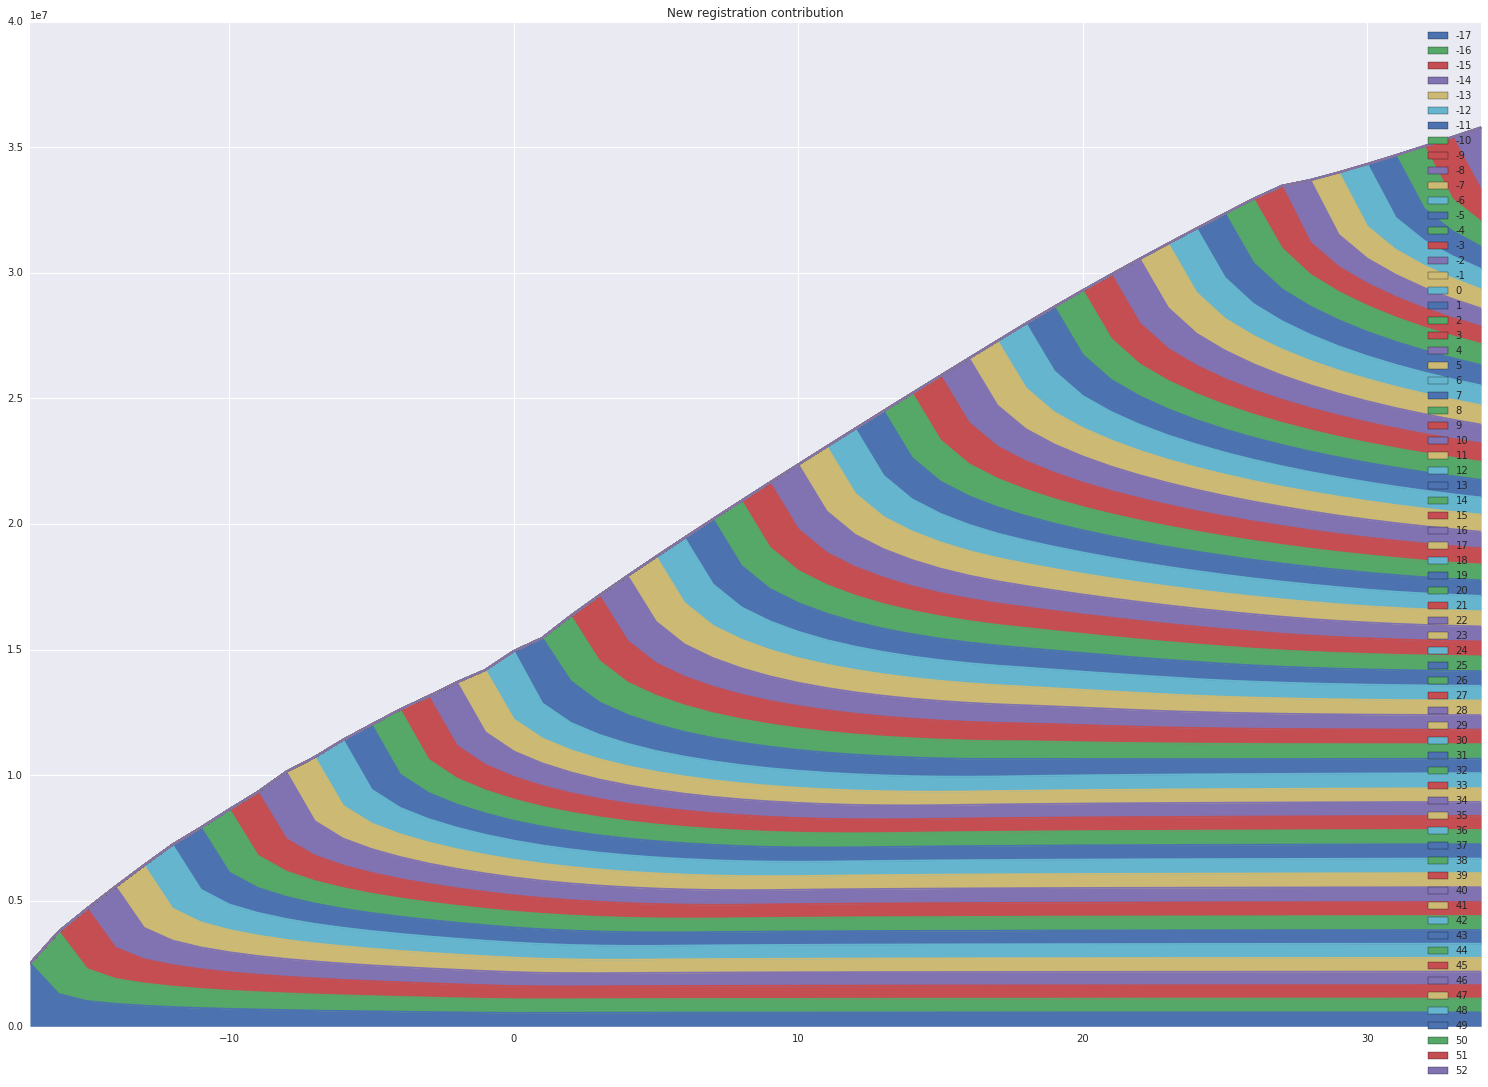

In [167]:
tot_new_users, active_new_users_per_cohort=return_all_new_users(new_regs, start, end, df_new_tp, 
                                                                df_new_tp_mod, ex_tp, ex_tp_mod, new_tp_weeks, num_forecast_weeks, ex_weeks_req)
active_new_users_per_cohort[0:52].plot(kind='area', figsize=(26,18), title='New registration contribution')

In [95]:
active_cohort=adding['Activate']+adding['Retain']+adding['Resurrect']

In [97]:
pd.DataFrame(active_cohort, columns=[52])

,52
52,2.447499e+06
53,1.255350e+06
54,9.806406e+05
55,8.700742e+05
56,8.019790e+05
57,7.474068e+05
58,7.086267e+05
59,6.776289e+05
60,6.529892e+05
61,6.294199e+05


In [89]:
a.add(pd.DataFrame([]), fill_value=0)

,RemainFTA,Activate,Retain,Churn,Resurrect,RemainDormant
5,633764.210552,2.912371e+06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
6,601476.403042,3.228781e+04,1.820456e+06,1.091916e+06,0.000000,0.000000e+00
7,585290.521920,1.618588e+04,1.311353e+06,5.413904e+05,117837.772873,9.740779e+05
8,575095.955795,1.019457e+04,1.126999e+06,3.183773e+05,144254.828226,1.371213e+06
9,567621.028161,7.474928e+03,1.030221e+06,2.512275e+05,142898.555069,1.546692e+06
10,561682.174389,5.938854e+03,9.573658e+05,2.232288e+05,136587.196367,1.661333e+06
11,556642.248512,5.039926e+03,9.045346e+05,1.953572e+05,132986.933422,1.751574e+06
12,552299.855622,4.342393e+03,8.634499e+05,1.791116e+05,128976.856768,1.817955e+06
13,548459.010485,3.840845e+03,8.314236e+05,1.653456e+05,125118.706594,1.871948e+06
14,545071.885741,3.387125e+03,8.015037e+05,1.588794e+05,120722.883506,1.916570e+06
